In [1]:
# packages we need:
import pandas as pd
import numpy as np
import glob
import os
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
# install them with pip if you do not have them

In [2]:
def read_in_data_from_folder(path = 'data/pl', columns_to_keep = ['Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'filename'], print=False):
    """
    Read in all csv files from a folder and concatonate it into one pandas dataframe.
    """
    all_files = glob.glob(os.path.join(path , "*.csv"))



    pd_base = pd.DataFrame()

    for filename in all_files:
        df = pd.read_csv(filename)
        df['filename'] = filename # add filename path as column
        pd_base = pd.concat([pd_base, df], ignore_index=True)
    
    # Keep only some columns
    # If columns_to_keep is not empty, keep only those columns. If empty, keep all columns:
    if columns_to_keep:
        pd_base = pd_base[columns_to_keep]

    # If there is a 'Date' column then convert it to datetime with format '%d/%m/%Y':
    if 'Date' in pd_base.columns:
        date1 = pd.to_datetime(pd_base['Date'], errors='coerce', format='%d/%m/%Y')
        date2 = pd.to_datetime(pd_base['Date'], errors='coerce', format='%d/%m/%y')
        pd_base['Date'] = date1.fillna(date2)
    
    pd_base = pd_base.sort_values(by='Date',ascending=True)
    return pd_base

In [3]:
results_data = read_in_data_from_folder(path = 'data/pl', columns_to_keep = ['Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'filename'], print=False)


In [4]:
results_data

,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,filename
0,1993-08-14,Arsenal,Coventry,0,3,A,data/pl/pl_1993_1994.csv
1,1993-08-14,Aston Villa,QPR,4,1,H,data/pl/pl_1993_1994.csv
2,1993-08-14,Chelsea,Blackburn,1,2,A,data/pl/pl_1993_1994.csv
3,1993-08-14,Liverpool,Sheffield Weds,2,0,H,data/pl/pl_1993_1994.csv
4,1993-08-14,Man City,Leeds,1,1,D,data/pl/pl_1993_1994.csv
...,...,...,...,...,...,...,...
11789,2024-02-04,Man United,West Ham,3,0,H,data/pl/pl_2023_2024.csv
11790,2024-02-04,Arsenal,Liverpool,3,1,H,data/pl/pl_2023_2024.csv
11787,2024-02-04,Bournemouth,Nott'm Forest,1,1,D,data/pl/pl_2023_2024.csv
11788,2024-02-04,Chelsea,Wolves,2,4,A,data/pl/pl_2023_2024.csv


In [5]:
def create_league_table(data):
    
    unique_team_names = data['HomeTeam'].unique()

    league_table = pd.DataFrame()

    league_table['team'] = unique_team_names
    league_table['ranking'] = 0
    league_table['points'] = 0
    league_table['w'] = 0
    league_table['d'] = 0
    league_table['l'] = 0
    league_table['goals_for'] = 0
    league_table['goals_against'] = 0
    league_table['goal_difference'] = 0
    league_table['matched_played'] = 0
    league_table['last_date'] = 0

    # if there is colname 'Date', then we can use it to update 'last_date' column:
    if 'Date' in data.columns:
        league_table['last_date'] = min(data['Date'])
    else:
        league_table['last_date'] = 0
    
    return league_table

In [6]:
results_data_2023 = results_data[results_data['filename'] == r'data/pl/pl_2022_2023.csv']
lt_2023 = create_league_table(results_data_2023)
#lt_2023

In [7]:
def update_league_table(league_table, results_table):

    league_table_all = league_table.copy()
    league_table_new = league_table.copy()

    for index, row in results_table.iterrows():
        # get team names
        home_team = row['HomeTeam']
        away_team = row['AwayTeam']
        # get match results
        home_team_goals = row['FTHG']
        away_team_goals = row['FTAG']
        full_time_result = row['FTR']
        # get date of match
        last_date = row['Date']

        # update 'matched_played' column:
        league_table_new.loc[league_table_new['team'] == home_team, 'matched_played'] += 1
        league_table_new.loc[league_table_new['team'] == away_team, 'matched_played'] += 1

        # update 'goals_for' and 'goals_against' columns:     
        league_table_new.loc[league_table_new['team'] == home_team, 'goals_for'] += home_team_goals
        league_table_new.loc[league_table_new['team'] == home_team, 'goals_against'] += away_team_goals
        league_table_new.loc[league_table_new['team'] == away_team, 'goals_for'] += away_team_goals
        league_table_new.loc[league_table_new['team'] == away_team, 'goals_against'] += home_team_goals

        # update 'last_date' column:
        league_table_new.loc[league_table_new['team'] == home_team, 'last_date'] = last_date

        # update 'ponts' and 'w', 'd', 'l' columns based on the result of the match:
        if full_time_result == 'H':
            league_table_new.loc[league_table_new['team'] == home_team, 'points'] += 3
            league_table_new.loc[league_table_new['team'] == away_team, 'points'] += 0

            league_table_new.loc[league_table_new['team'] == home_team, 'w'] += 1
            league_table_new.loc[league_table_new['team'] == away_team, 'l'] += 1

        elif full_time_result == 'A':
            league_table_new.loc[league_table_new['team'] == home_team, 'points'] += 0
            league_table_new.loc[league_table_new['team'] == away_team, 'points'] += 3

            league_table_new.loc[league_table_new['team'] == home_team, 'l'] += 1
            league_table_new.loc[league_table_new['team'] == away_team, 'w'] += 1
            
        elif full_time_result == 'D':
            league_table_new.loc[league_table_new['team'] == home_team, 'points'] += 1
            league_table_new.loc[league_table_new['team'] == away_team, 'points'] += 1

            league_table_new.loc[league_table_new['team'] == home_team, 'd'] += 1
            league_table_new.loc[league_table_new['team'] == away_team, 'd'] += 1
        else:
            print('Error: FTR is not H, A or D')

        # update 'goal_difference' column:
        league_table_new['goal_difference'] = league_table_new['goals_for'] - league_table_new['goals_against']

        # crate ranking based on points, goal difference, goals for and goals against
        league_table_new = league_table_new.sort_values(by=['points', 'goal_difference', 'goals_for', 'goals_against'], ascending=False)
        league_table_new = league_table_new.reset_index(drop=True)
        league_table_new['ranking'] = league_table_new.index + 1
        
        # update our data
        updated_row = league_table_new[(league_table_new['team'] == home_team) | (league_table_new['team'] == away_team)]
        league_table_all = pd.concat([league_table_all, updated_row], ignore_index=True)

    # reorder rows based on column points and goals_for:
    league_table_new = league_table_new.sort_values(by=['points', 'goal_difference', 'goals_for', 'goals_against'], ascending=False)
    league_table_new = league_table_new.reset_index(drop=True)
    
    return league_table_new, league_table_all

In [8]:
#results = results_data
results = results_data_2023
table_data = create_league_table(results)
new_table_data,  league_table_all= update_league_table(table_data, results)

In [9]:
new_table_data

,team,ranking,points,w,d,l,goals_for,goals_against,goal_difference,matched_played,last_date
0,Man City,1,89,28,5,5,94,33,61,38,2023-05-21
1,Arsenal,2,84,26,6,6,88,43,45,38,2023-05-28
2,Man United,3,75,23,6,9,58,43,15,38,2023-05-28
3,Newcastle,4,71,19,14,5,68,33,35,38,2023-05-22
4,Liverpool,5,67,19,10,9,75,47,28,38,2023-05-20
5,Brighton,6,62,18,8,12,72,53,19,38,2023-05-24
6,Aston Villa,7,61,18,7,13,51,46,5,38,2023-05-28
7,Tottenham,8,60,18,6,14,70,63,7,38,2023-05-20
8,Brentford,9,59,15,14,9,58,46,12,38,2023-05-28
9,Fulham,10,52,15,7,16,55,53,2,38,2023-05-20


Text(0.5, 1.0, 'Premier League 2022-2023 final results')

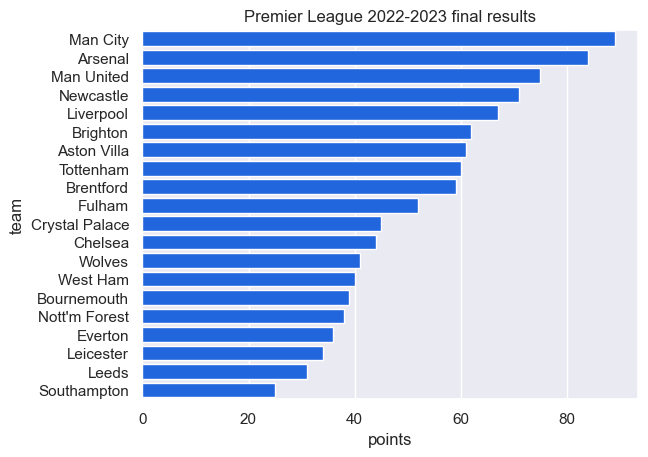

In [10]:
sns.barplot(x = 'points', y = 'team', data = new_table_data, color = '#035efc')
plt.title('Premier League 2022-2023 final results')

Text(0.5, 1.0, 'Premier League avarage points/ match in the 2022-2023 season')

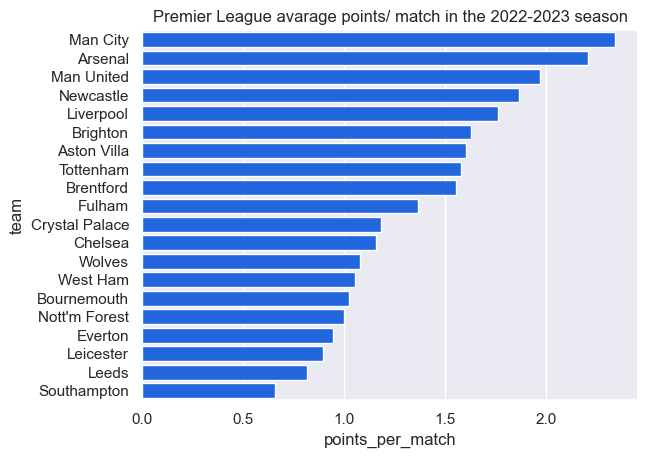

In [11]:
new_table_data['points_per_match'] = new_table_data['points'] / new_table_data['matched_played']
sns.barplot(x = 'points_per_match', y = 'team', data = new_table_data, color = '#035efc', order=new_table_data.sort_values('points_per_match', ascending = False).team)
plt.title('Premier League avarage points/ match in the 2022-2023 season')

/home/phil/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/phil/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.0, 'Premier League points over time')

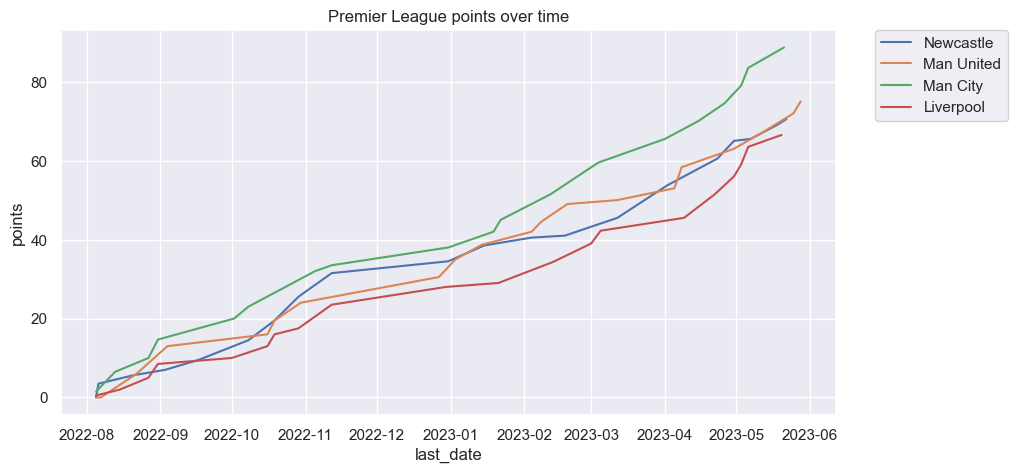

In [12]:
plt.figure(figsize = (10,5))
sns.lineplot(x='last_date', y='points', hue='team', errorbar=None,
    data=league_table_all[league_table_all['team'].isin(['Liverpool', 'Man City', 'Newcastle','Man United'])])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Premier League points over time')

In [13]:
def create_league_table_elo(data, default_elo = 1500):
    unique_team_names = data['HomeTeam'].unique()

    league_table = pd.DataFrame()

    league_table['team'] = unique_team_names
    league_table['ranking'] = 0
    
    #we need to add the 'elo' column to the dataframe
    league_table['elo'] = default_elo
    
    league_table['points'] = 0
    league_table['w'] = 0
    league_table['d'] = 0
    league_table['l'] = 0
    league_table['goals_for'] = 0
    league_table['goals_against'] = 0
    league_table['goal_difference'] = 0
    league_table['matched_played'] = 0

    # if there is colname 'Date', then we can use it to update 'last_date' column:
    if 'Date' in data.columns:
        league_table['last_date'] = min(data['Date'])
    else:
        league_table['last_date'] = 0
    
    return league_table

In [14]:
results_data = read_in_data_from_folder(path = 'data/pl', columns_to_keep = ['Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'filename'], print=False)
league_table_elo = create_league_table_elo(results_data, default_elo = 1400)
print(league_table_elo['team'].to_list())

['Arsenal', 'Aston Villa', 'Chelsea', 'Liverpool', 'Man City', 'Newcastle', 'Oldham', 'Sheffield United', 'Southampton', 'West Ham', 'Norwich', 'Tottenham', 'Wimbledon', 'Leeds', 'Ipswich', 'Everton', 'Blackburn', 'Coventry', 'Man United', 'QPR', 'Sheffield Weds', 'Swindon', 'Crystal Palace', 'Leicester', "Nott'm Forest", 'Bolton', 'Middlesbrough', 'Sunderland', 'Derby', 'Barnsley', 'Charlton', 'Watford', 'Bradford', 'Fulham', 'West Brom', 'Birmingham', 'Portsmouth', 'Wolves', 'Wigan', 'Reading', 'Hull', 'Stoke', 'Burnley', 'Blackpool', 'Swansea', 'Cardiff', 'Bournemouth', 'Brighton', 'Huddersfield', 'Brentford', 'Luton']


In [15]:
def expected_result_prob(home_score,away_score, weight = 400, home_field_advantage = 50):
  # calculate the expected probabilities for a match between two teams
  diff_h_a = home_score - away_score + home_field_advantage #here we can add home field advantage
  
  we = (1/(10 ** (-diff_h_a/weight)+1)) #the actual formula to calculate the expected probability
  
  home_team_prop = np.round(we,3)
  away_team_prob = 1-home_team_prop
  away_team_prob = np.round(away_team_prob,3)
  return home_team_prop, away_team_prob

In [16]:
print(expected_result_prob(1500,1400, weight=400))
print(expected_result_prob(1600,1400, weight=400))
print(expected_result_prob(1500,1400, weight=200))
print(expected_result_prob(1500,1400, weight=600))

(0.703, 0.297)
(0.808, 0.192)
(0.849, 0.151)
(0.64, 0.36)


In [17]:
def actual_result(result):
  if result == 'H':
      home_team=1
      away_team=0
  elif result == 'A':
      home_team=0
      away_team=1
  elif result == 'D':
      home_team=0.5
      away_team=0.5
  return home_team, away_team

In [18]:
print(actual_result('H'))
print(actual_result('A'))
print(actual_result('D'))

(1, 0)
(0, 1)
(0.5, 0.5)


In [19]:
def calculate_elo(elo_home, elo_away, final_result, k_value = 40, weight = 400, home_field_advantage = 50):
  
  k=k_value

  erh, era = expected_result_prob(elo_home,elo_away, weight = weight, home_field_advantage = home_field_advantage)
  arh, ara = actual_result(final_result)

  # the actual formula to calculate the new elo
  updated_elo_home=elo_home + k*(arh-erh)
  updated_elo_away=elo_away + k*(ara-era)

  # round to nearest integer
  updated_elo_home=np.round(updated_elo_home, 3)
  updated_elo_away=np.round(updated_elo_away, 3)

  # just to calculate the stakes
  win_home = (1 - erh) * k
  lose_home = (0 - erh) * k
  draw_home = (0.5 - erh) * k
  win_away = (1 - era) * k
  lose_away = (0 - era) * k
  draw_away = (0.5 - era) * k
  stakes = [win_home, lose_home, draw_home, win_away, lose_away, draw_away]
  
  return updated_elo_home, updated_elo_away, stakes

In [20]:
calculate_elo(1500, 1400, 'H')

(1511.88,
 1388.12,
 [11.880000000000003,
  -28.119999999999997,
  -8.119999999999997,
  28.120000000000005,
  -11.879999999999999,
  8.120000000000001])

In [21]:
calculate_elo(1500, 1400, 'A')

(1471.88,
 1428.12,
 [11.880000000000003,
  -28.119999999999997,
  -8.119999999999997,
  28.120000000000005,
  -11.879999999999999,
  8.120000000000001])

Extend the league table updater function with the ELO calculations:

In [22]:
def update_league_table(league_table, results_table, k_value = 40, weight = 400, home_field_advantage = 50):

    league_table_all = league_table.copy()
    league_table_new = league_table.copy()

    for index, row in results_table.iterrows():
        # get team names
        home_team = row['HomeTeam']
        away_team = row['AwayTeam']
        # get match results
        home_team_goals = row['FTHG']
        away_team_goals = row['FTAG']
        full_time_result = row['FTR']
        # get date of match
        last_date = row['Date']
        # get elo of teams
        #print(last_date,home_team,away_team)
        
        home_team_elo = league_table_new[league_table_new['team'] == home_team]['elo'].values[0]
        away_team_elo = league_table_new[league_table_new['team'] == away_team]['elo'].values[0]

        # update 'matched_played' column:
        league_table_new.loc[league_table_new['team'] == home_team, 'matched_played'] += 1
        league_table_new.loc[league_table_new['team'] == away_team, 'matched_played'] += 1

        # update 'goals_for' and 'goals_against' columns:     
        league_table_new.loc[league_table_new['team'] == home_team, 'goals_for'] += home_team_goals
        league_table_new.loc[league_table_new['team'] == home_team, 'goals_against'] += away_team_goals
        league_table_new.loc[league_table_new['team'] == away_team, 'goals_for'] += away_team_goals
        league_table_new.loc[league_table_new['team'] == away_team, 'goals_against'] += home_team_goals

        # update 'last_date' column:
        league_table_new.loc[league_table_new['team'] == home_team, 'last_date'] = last_date

        # update 'ponts' and 'w', 'd', 'l' columns based on the result of the match:
        if full_time_result == 'H':
            league_table_new.loc[league_table_new['team'] == home_team, 'points'] += 3
            league_table_new.loc[league_table_new['team'] == away_team, 'points'] += 0

            league_table_new.loc[league_table_new['team'] == home_team, 'w'] += 1
            league_table_new.loc[league_table_new['team'] == away_team, 'l'] += 1

        elif full_time_result == 'A':
            league_table_new.loc[league_table_new['team'] == home_team, 'points'] += 0
            league_table_new.loc[league_table_new['team'] == away_team, 'points'] += 3

            league_table_new.loc[league_table_new['team'] == home_team, 'l'] += 1
            league_table_new.loc[league_table_new['team'] == away_team, 'w'] += 1
            
        elif full_time_result == 'D':
            league_table_new.loc[league_table_new['team'] == home_team, 'points'] += 1
            league_table_new.loc[league_table_new['team'] == away_team, 'points'] += 1

            league_table_new.loc[league_table_new['team'] == home_team, 'd'] += 1
            league_table_new.loc[league_table_new['team'] == away_team, 'd'] += 1
        else:
            print('Error: FTR is not H, A or D')

        # update 'elo' score based on the result of the match:
        new_home_elo_score, new_away_elo_score, _ = calculate_elo(home_team_elo, away_team_elo, full_time_result, k_value = k_value, weight = weight, home_field_advantage = home_field_advantage)
        league_table_new.loc[league_table_new['team'] == home_team, 'elo'] = new_home_elo_score
        league_table_new.loc[league_table_new['team'] == away_team, 'elo'] = new_away_elo_score

        # update 'goal_difference' column:
        league_table_new['goal_difference'] = league_table_new['goals_for'] - league_table_new['goals_against']

        # crate ranking based on points, goal difference, goals for and goals against
        league_table_new = league_table_new.sort_values(by=['points', 'goal_difference', 'goals_for', 'goals_against'], ascending=False)
        league_table_new = league_table_new.reset_index(drop=True)
        league_table_new['ranking'] = league_table_new.index + 1
        
        # update our data
        updated_row = league_table_new[(league_table_new['team'] == home_team) | (league_table_new['team'] == away_team)]
        league_table_all = pd.concat([league_table_all, updated_row], ignore_index=True)

    # reorder rows based on column points and goals_for:
    league_table_new = league_table_new.sort_values(by=['points', 'goal_difference', 'goals_for', 'goals_against'], ascending=False)
    league_table_new = league_table_new.reset_index(drop=True)
    
    return league_table_new, league_table_all

In [23]:
results = read_in_data_from_folder(path = 'data/pl', columns_to_keep = ['Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 'filename'], print=False)
league_table_elo = create_league_table_elo(results, default_elo=1400)
league_table_elo, league_table_elo_all = update_league_table(league_table_elo, results, k_value = 40, weight = 400, home_field_advantage = 60)

/tmp/ipykernel_2285/3602946622.py:61: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '1376.6' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  league_table_new.loc[league_table_new['team'] == home_team, 'elo'] = new_home_elo_score


In [24]:
league_table_elo.sort_values("elo",ascending=False)


,team,ranking,elo,points,w,d,l,goals_for,goals_against,goal_difference,matched_played,last_date
5,Man City,6,1744.92,1710,501,207,272,1750,1075,675,980,2024-01-31
2,Liverpool,3,1710.44,2168,627,287,257,2086,1161,925,1171,2024-01-31
1,Arsenal,2,1677.60,2218,645,283,243,2112,1175,937,1171,2024-02-04
8,Aston Villa,9,1619.76,1391,365,296,396,1308,1389,-81,1057,2024-01-30
4,Tottenham,5,1597.52,1832,517,281,373,1804,1470,334,1171,2024-01-31
0,Man United,1,1592.60,2395,714,253,204,2207,1110,1097,1171,2024-02-04
30,Brighton,31,1536.72,306,75,81,95,304,349,-45,251,2024-02-03
7,Newcastle,8,1533.76,1514,411,281,403,1493,1487,6,1095,2024-02-03
9,West Ham,10,1519.28,1334,356,266,435,1313,1520,-207,1057,2024-02-01
21,Wolves,22,1509.76,421,110,91,164,396,557,-161,365,2024-02-01


/home/phil/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/phil/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.0, 'ELO score progression for some PL clubs')

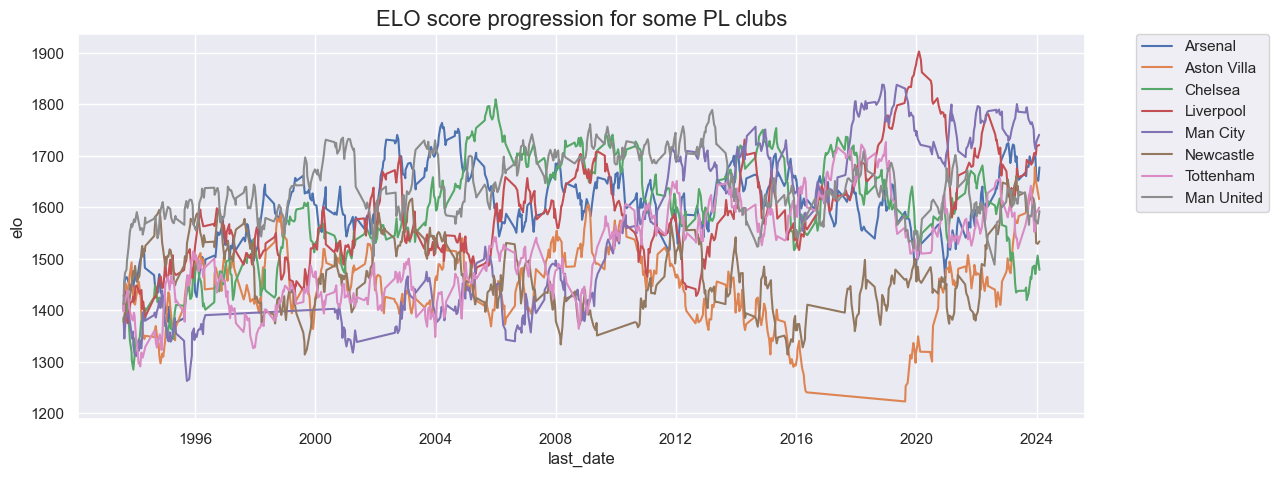

In [28]:
plt.figure(figsize = (13,5))
sns.lineplot(x='last_date', y='elo', hue='team', errorbar=None,
    data=league_table_elo_all[league_table_elo_all['team'].isin(['Aston Villa','Tottenham',"Man United",'Arsenal',"Liverpool","Man City","Chelsea","Newcastle"])])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('ELO score progression for some PL clubs', size = 16)

Zoomed in:

/home/phil/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/phil/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0.5, 1.0, 'ELO score progression for some PL clubs')

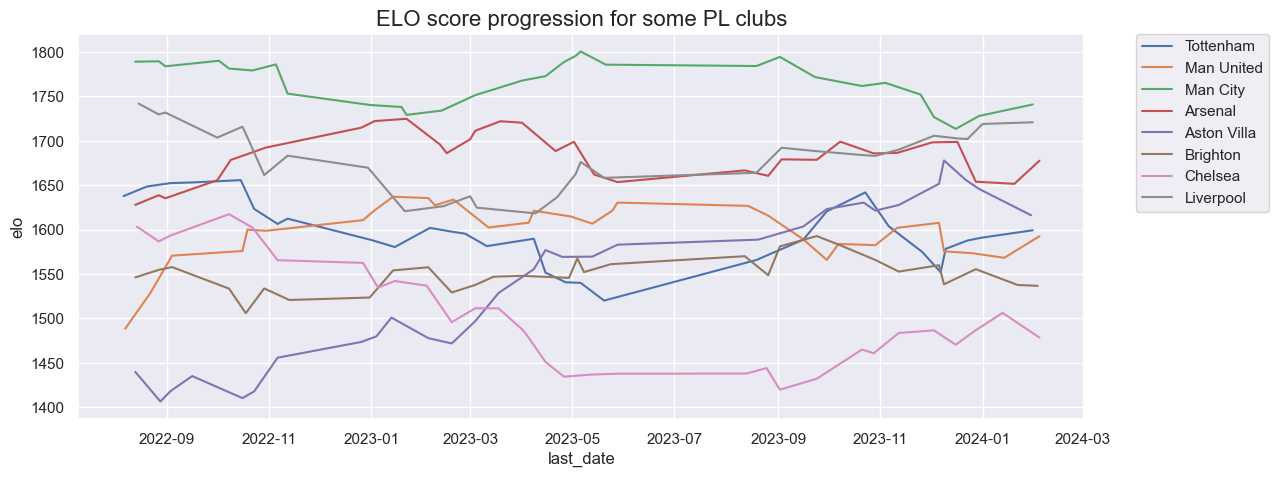

In [26]:
plt.figure(figsize = (13,5))
sns.lineplot(x='last_date', y='elo', hue='team', errorbar=None,
    data=league_table_elo_all[(league_table_elo_all['team'].isin(['Aston Villa','Tottenham',"Man United",'Arsenal',"Liverpool","Man City","Chelsea","Brighton"])) & (league_table_elo_all['last_date'] > '2022-08-01')])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('ELO score progression for some PL clubs', size = 16)

/tmp/ipykernel_2285/3785798698.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x='matched_played', y='elo', hue='team', ci = None,
/home/phil/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/home/phil/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


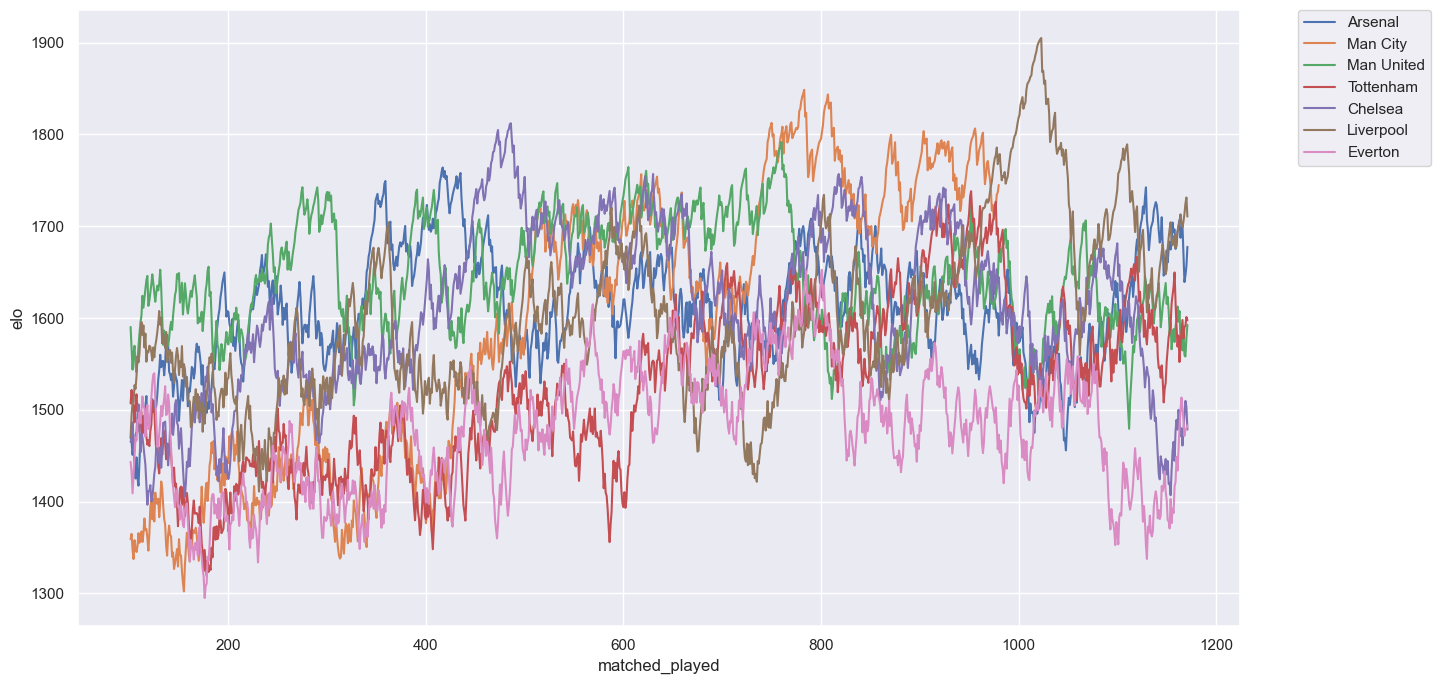

In [27]:
plt.figure(figsize = (15,8))
sns.lineplot(x='matched_played', y='elo', hue='team', ci = None,
    data=league_table_elo_all[(league_table_elo_all['team'].isin(['Arsenal', 'Chelsea', 'Liverpool', 'Man City', 'Man United', 'Tottenham', 'Everton'])) & (league_table_elo_all['matched_played'] > 100)])
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# Summary: